## The contents include:

* 6. Analyzing RNAseq data with the edgeR package
* 7. The differential analysis of NGS data using limma
* 8. Enriching RNAseq data with GO terms
* 9. The KEGG enrichment of sequence data
* 10. Analyzing methylation data
* 11. Analyzing ChipSeq data

## 6. Analyzing RNAseq data with the `edgeR` package

To determine whether the count for a transcript is significantly different or differentially expressed under the treatment condition, we need to do a differential count analysis for the data.<br> 

为了确定转录本的计数是否在处理条件下显着不同或差异表达，我们需要对数据进行差异计数分析。<br>

To perform differential analysis for the RNAseq data, we will need two R packages, namely, `edgeR` and `goseq`, for the recipe, and use the dataset: the default data for these packages. The data comes from an experiment that examined the effect of androgen stimulation on a human prostate cancer cell line, LNCaP. The data has four control and three treated samples.<br>

在本节内容里，为了实现对RNA-seq数据的差异分析，我们需要两个R包，即`edgeR`和`goseq`，并使用数据集：这些包的默认数据。数据来自一项实验，该实验检测雄激素刺激对人前列腺癌细胞系LNCaP的影响。 数据有四个对照样品和三个处理过的样品。

The `edgeR` package uses the count data by modeling it via an overdispersed Poisson model, assuming it to be a negative binomial distribution. Then, it follows an Empirical Bayes procedure to moderate the degree of overdispersion across genes by conditional maximum likelihood, conditioned on the total count for that gene (step 5). To compute the differential expression of a tag/gene, a Fisher's exact test (step 6) is performed, yielding the corresponding statistical scores. Finally, the top ranking tags (according to the p-values) are returned in steps 7. The `topTags` function, by default, returns the top 10 results; we can return desired number of top ranked tags by setting the argument n to this number in the function.

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
install.packages("BiocManager")
BiocManager::install("edgeR")
BiocManager::install("goseq")

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'edgeR'



package 'edgeR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Master\AppData\Local\Temp\RtmpiWAE7A\downloaded_packages


Old packages: 'BH', 'bit', 'caTools', 'cli', 'FactoMineR', 'fansi', 'farver',
  'GetoptLong', 'ggridges', 'gplots', 'hms', 'knitr', 'leaps', 'multcomp',
  'mvtnorm', 'PMA', 'precrec', 'prettyunits', 'pROC', 'RCurl', 'RSQLite',
  'Rttf2pt1', 'shinyjs', 'stringi', 'tinytex', 'xfun', 'XML', 'xts', 'zoo'

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'goseq'

also installing the dependencies 'BiasedUrn', 'geneLenDataBase'




package 'BiasedUrn' successfully unpacked and MD5 sums checked
package 'goseq' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Master\AppData\Local\Temp\RtmpiWAE7A\downloaded_packages


installing the source package 'geneLenDataBase'


Old packages: 'BH', 'bit', 'caTools', 'cli', 'FactoMineR', 'fansi', 'farver',
  'GetoptLong', 'ggridges', 'gplots', 'hms', 'knitr', 'leaps', 'multcomp',
  'mvtnorm', 'PMA', 'precrec', 'prettyunits', 'pROC', 'RCurl', 'RSQLite',
  'Rttf2pt1', 'shinyjs', 'stringi', 'tinytex', 'xfun', 'XML', 'xts', 'zoo'



In [2]:
library(edgeR)
library(goseq)

Loading required package: limma

Loading required package: BiasedUrn

Loading required package: geneLenDataBase





In [3]:
## Read in the input data from the `goseq` library data directory，and take a look at the content of a part of the data
myData <- read.table(system.file("extdata", "Li_sum.txt", package='goseq'), sep = '\t', 
                     header = TRUE, stringsAsFactors = FALSE,row.names=1)
head(myData)

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0


In [4]:
## The first four columns in the data are controls and the last three are the treatment samples. 
## Assign these attributes to the data
myTreat <- factor(rep(c("Control","Treatment"),times = c(4,3)))

In [5]:
## Create a `DGElist` object using all the count data and treatment information
myDG <- DGEList(myData,lib.size = colSums(myData),group = myTreat)
# The `DGElist` object is a list with two components: counts and sample (treatment information).
myDG

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0
ENSG00000243140,0,0,0,0,0,0,0
ENSG00000240187,0,0,0,0,0,0,0
ENSG00000241444,0,0,0,0,0,0,0
ENSG00000242468,0,0,0,0,0,0,0


In [6]:
## Estimate the dispersion in the data, and then use Fisher's exact test
myDisp <- estimateCommonDisp(myDG)
mytest <- exactTest(myDisp)

In [7]:
## Extract the top DE tags ranked by the p-value (or the absolute log fold change) using `topTags` function, 
## and to see the results by `as.data.frame` function
myRes <- topTags(mytest, sort.by = "PValue")
summary(myRes)
as.data.frame(myRes)

              Length Class      Mode     
table         4      data.frame list     
adjust.method 1      -none-     character
comparison    2      -none-     character
test          1      -none-     character

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000127954,11.557868,6.680748,2.574972e-80,1.274766e-75
ENSG00000151503,5.398963,8.499530,1.781732e-65,4.410321e-61
ENSG00000096060,4.897600,9.446705,7.983756e-60,1.317479e-55
ENSG00000091879,5.737627,6.282646,1.207655e-54,1.494654e-50
ENSG00000132437,-5.880436,7.951910,2.950042e-52,2.920896e-48
ENSG00000166451,4.564246,8.458467,7.126763e-52,5.880292e-48
ENSG00000131016,5.254737,6.607957,1.066807e-51,7.544766e-48
ENSG00000163492,7.085400,5.128514,2.716461e-45,1.681014e-41
ENSG00000113594,4.051053,8.603264,9.272066e-44,5.100255e-40


## 7. The differential analysis of NGS data using limma

In part(1), we have learned how to find differentially expressed genes in analyzing microarray data by `limma`. It can handle multiple experiments via Empirical Bayes statistical methods and uses normalized read counts for each gene. This section will explain the use of the `limma` package for differential gene analysis with NGS data.<br>

Besides using the `limma` library, we will use the `Pasilla` dataset here. The dataset can be obtained from Bioconductor and consists of sequence counts from a perturbation experiment in Drosophila. To know more about the data, refer to [the Conservation of an RNA regulatory map between Drosophila and mammals article by Brooks and others](http://genome.cshlp.org/content/early/2010/10/04/gr.108662.110).

In [8]:
# install
BiocManager::install(c("DESeq","pasilla", "survival"))

library(limma)                #load 
library(DESeq)                #load
library(pasilla)              #load
library(survival)             #load
data(pasillaGenes)            #check the data

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'DESeq', 'pasilla', 'survival'



package 'DESeq' successfully unpacked and MD5 sums checked
package 'survival' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'survival'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying D:\R-3.6.2\library\00LOCK\survival\libs\x64\survival.dll to D:\R-3.6.2\library\survival\libs\x64\survival.dll: Permission denied"
Warning message:
"restored 'survival'"



The downloaded binary packages are in
	C:\Users\Master\AppData\Local\Temp\RtmpiWAE7A\downloaded_packages


installing the source package 'pasilla'


Old packages: 'BH', 'bit', 'caTools', 'cli', 'FactoMineR', 'fansi', 'farver',
  'GetoptLong', 'ggridges', 'gplots', 'hms', 'knitr', 'leaps', 'multcomp',
  'mvtnorm', 'PMA', 'precrec', 'prettyunits', 'pROC', 'RCurl', 'RSQLite',
  'Rttf2pt1', 'shinyjs', 'stringi', 'tinytex', 'xfun', 'XML', 'xts', 'zoo'

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from 'package:limma':

    plotMA


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplic

In [9]:
## Create an expression set using the counts from the `pasillaGenes` dataset and take a look at it, 
## we will find seven samples in the dataset: the first three are the treatment samples and the last four are controls. 
## Assign this 7 samples to our `eset` data, and check it.
eset <- counts(pasillaGenes)      #create
colnames(eset) <- c(paste("T", 1:3, sep="_"), paste("C", 1:4, sep="_"))   #assign the data
head(eset)   # check the assigned data

,T_1,T_2,T_3,C_1,C_2,C_3,C_4
FBgn0000003,0,0,1,0,0,0,0
FBgn0000008,78,46,43,47,89,53,27
FBgn0000014,2,0,0,0,0,1,0
FBgn0000015,1,0,1,0,1,1,2
FBgn0000017,3187,1672,1859,2445,4615,2063,1711
FBgn0000018,369,150,176,288,383,135,174


In [10]:
## Create a design matrix，and perform a `voom` transformation using the experiment design matrix
design <- cbind(Intercept=1,trt=c(1,1,1,0,0,0,0))    # add a new column to the `eset` data
eset_voom <- voom(eset, design, plot=FALSE)          # perform voom transformation
eset_voom

,T_1,T_2,T_3,C_1,C_2,C_3,C_4
FBgn0000003,-4.30792027,-3.50962618,-2.1190901,-3.87180837,-4.5531169,-3.4137300,-3.5722974
FBgn0000008,2.98670048,3.02953264,2.7388909,2.69804724,2.9306989,3.3277370,2.2090623
FBgn0000014,-1.98599217,-3.50962618,-3.7040526,-3.87180837,-4.5531169,-1.8287675,-3.5722974
FBgn0000015,-2.72295777,-3.50962618,-2.1190901,-3.87180837,-2.9681544,-1.8287675,-1.2503693
FBgn0000017,8.33028936,8.19816432,8.1566465,8.38410538,8.6191543,8.5971477,8.1687481
FBgn0000018,5.22151028,4.72399350,4.7594718,5.30061914,5.0299658,4.6684190,4.8747858
FBgn0000022,-4.30792027,-3.50962618,-3.7040526,-3.87180837,-2.9681544,-3.4137300,-3.5722974
FBgn0000024,-1.13799527,-0.05019456,-0.8966977,-0.70188337,-0.6462263,-1.8287675,-3.5722974
FBgn0000028,-4.30792027,-1.92466367,-2.1190901,-3.87180837,-2.9681544,-3.4137300,-3.5722974
FBgn0000032,6.57242854,6.35301118,6.3633818,6.71221457,6.3485042,6.4458048,6.3088165


In [11]:
## Fit a linear model on the `eset` data and design matrix， and use `eBayes` to perform the computation of statistics
fit <- lmFit(eset_voom,design)
fitE <- eBayes(fit)

In [12]:
## Use `topTable` function to find the top genes and filter them based on the corresponding p-values
topAll <- topTable(fitE, n=nrow(eset), coef = 2, adjust = "BH")
topAll
DEgenes <- rownames(topAll[which(topAll$adj.P.Val<0.05),])
DEgenes

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FBgn0029167,-2.1473232,7.8828594,-22.057481,3.268794e-10,2.875966e-06,13.859933
FBgn0035085,-2.4294695,5.2437331,-19.828037,9.885392e-10,4.768054e-06,12.308149
FBgn0039155,-4.3966425,4.8505796,-21.646659,3.975074e-10,2.875966e-06,11.973515
FBgn0001226,1.7553191,6.3299240,14.065912,3.340458e-08,7.614614e-05,9.525138
FBgn0011260,2.4179643,3.8409988,14.108427,3.239964e-08,7.614614e-05,9.203474
FBgn0034736,-3.2489931,3.3469966,-15.562978,1.194885e-08,4.322496e-05,9.079040
FBgn0029896,-2.5112555,4.6935590,-13.623414,4.613932e-08,7.614614e-05,8.938973
FBgn0000071,2.7514504,4.0544440,13.172847,6.474037e-08,9.367931e-05,8.650658
FBgn0051092,2.4912495,3.1985276,13.588162,4.736111e-08,7.614614e-05,8.632674


[1] "FBgn0029167"                        
  [2] "FBgn0035085"                        
  [3] "FBgn0039155"                        
  [4] "FBgn0001226"                        
  [5] "FBgn0011260"                        
  [6] "FBgn0034736"                        
  [7] "FBgn0029896"                        
  [8] "FBgn0000071"                        
  [9] "FBgn0051092"                        
 [10] "FBgn0040091"                        
 [11] "FBgn0026562"                        
 [12] "FBgn0023479"                        
 [13] "FBgn0003501"                        
 [14] "FBgn0033764"                        
 [15] "FBgn0003137"                        
 [16] "FBgn0003748"                        
 [17] "FBgn0035189"                        
 [18] "FBgn0001225"                        
 [19] "FBgn0031191+FBgn0027279"            
 [20] "FBgn0001258"                        
 [21] "FBgn0039479"                        
 [22] "FBgn0034897"                        
 [23] "FBgn0034434"                        
 [24] "FBgn0001224"                        
 [25] "FBgn0033913"                        
 [26] "FBgn0037290"                        
 [27] "FBgn0034751"                        
 [28] "FBgn0260011"                        
 [29] "FBgn0037153"                        
 [30] "FBgn0024288"                        
 [31] "FBgn0051642"                        
 [32] "FBgn0034438"                        
 [33] "FBgn0038149"                        
 [34] "FBgn0039109"                        
 [35] "FBgn0063649"                        
 [36] "FBgn0038832"                        
 [37] "FBgn0039419"                        
 [38] "FBgn0050147"                        
 [39] "FBgn0016715"                        
 [40] "FBgn0261362"                        
 [41] "FBgn0035968"                        
 [42] "FBgn0261238"                        
 [43] "FBgn0040271"                        
 [44] "FBgn0032405"                        
 [45] "FBgn0034405"                        
 [46] "FBgn0003076"                        
 [47] "FBgn0261552"                        
 [48] "FBgn0004108"                        
 [49] "FBgn0039113"                        
 [50] "FBgn0051038"                        
 [51] "FBgn0036299"                        
 [52] "FBgn0025111+FBgn0003360"            
 [53] "FBgn0001124"                        
 [54] "FBgn0038528"                        
 [55] "FBgn0027515"                        
 [56] "FBgn0031150"                        
 [57] "FBgn0031327"                        
 [58] "FBgn0020248"                        
 [59] "FBgn0052407"                        
 [60] "FBgn0015568"                        
 [61] "FBgn0030805"                        
 [62] "FBgn0024315"                        
 [63] "FBgn0051195"                        
 [64] "FBgn0038293"                        
 [65] "FBgn0261284"                        
 [66] "FBgn0033367"                        
 [67] "FBgn0036968"                        
 [68] "FBgn0040827"                        
 [69] "FBgn0038341"                        
 [70] "FBgn0038198"                        
 [71] "FBgn0000116"                        
 [72] "FBgn0038805"                        
 [73] "FBgn0035147"                        
 [74] "FBgn0036684"                        
 [75] "FBgn0003502"                        
 [76] "FBgn0034010"                        
 [77] "FBgn0030598"                        
 [78] "FBgn0035765"                        
 [79] "FBgn0029801"                        
 [80] "FBgn0033724"                        
 [81] "FBgn0086910"                        
 [82] "FBgn0039827"                        
 [83] "FBgn0051363"                        
 [84] "FBgn0036007"                        
 [85] "FBgn0035403"                        
 [86] "FBgn0050463"                        
 [87] "FBgn0033095"                        
 [88] "FBgn0024984"                        
 [89] "FBgn0003317"                        
 [90] "FBgn0031805"                        
 [91] "FBgn0051523"                       

The `limma` analysis for a data has already been described in Chapter 5, Analyzing Microarray Data with R. In this part, we used the `count data` in place of `normalized expression values`. Another difference is the use of the `voom transformation` that estimates the mean-variance relationship for the log counts, which robustly generates a precision weight for each individual normalized observation. The plot shown in the following plots shows a histogram of the tags with different ranges of p-values and a volcano plot for the `limma` analysis.

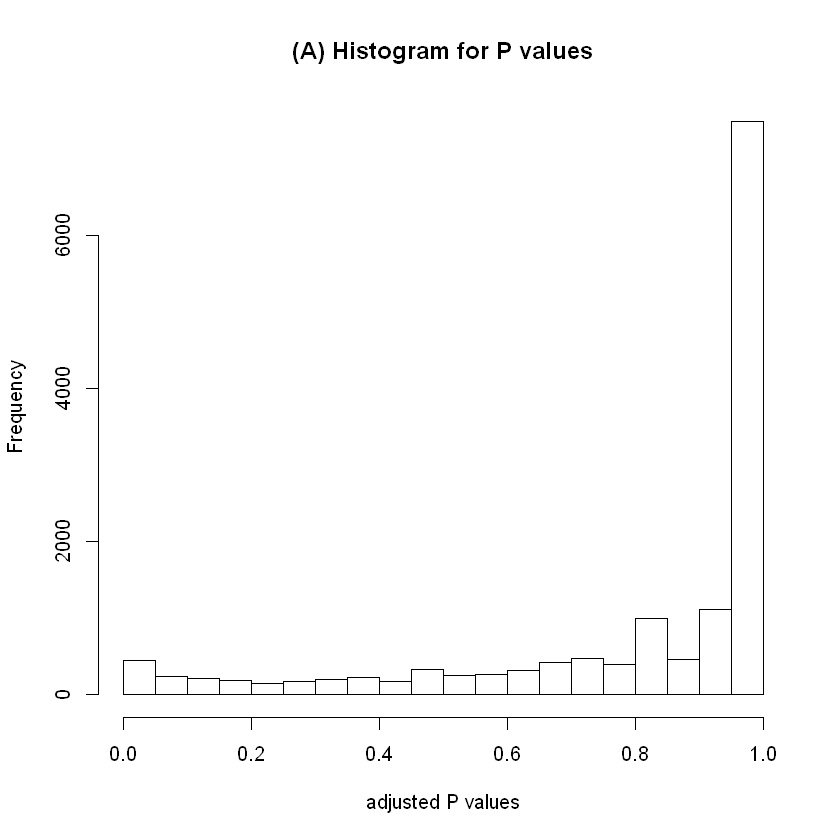

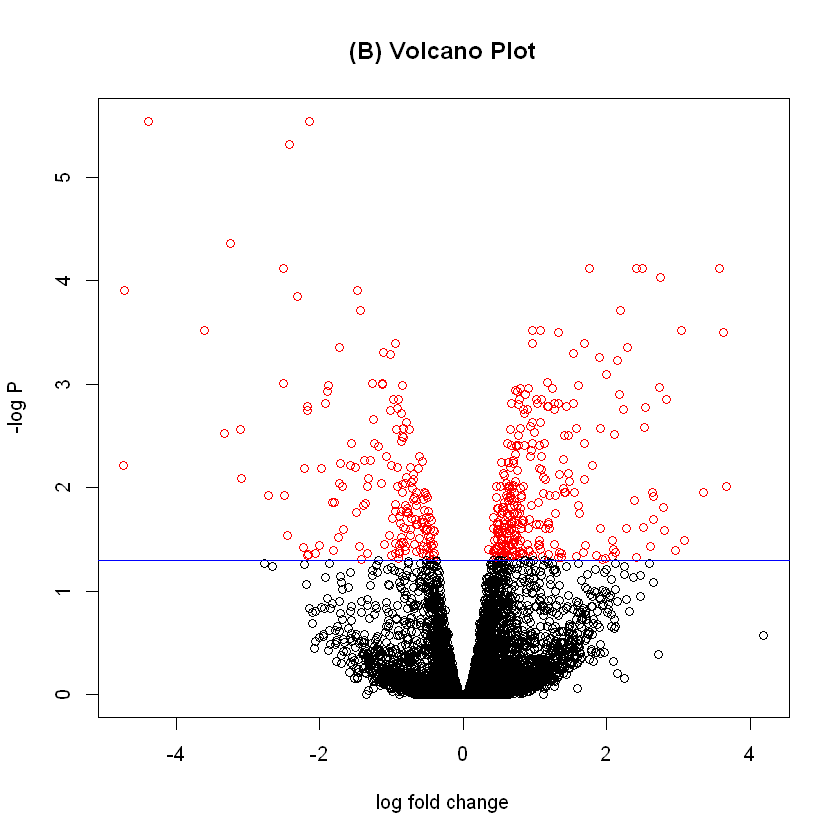

In [13]:
hist(topAll$adj.P.Val, xlab="adjusted P values",main="(A) Histogram for P values")
clr <- rep("black",nrow(topAll)) # creates a vector for color
clr[which(topAll$adj.P.Val<0.05)] <- "red"# sets color for DE to red
plot(x = topAll$logFC, y = -log10(topAll$adj.P.Val), col = clr, xlab = "log fold change", 
     ylab = "-log P",main = "(B) Volcano Plot") # Do a volcano plot
abline(h=-log10(0.05), col="blue")# Draw a horizontal line marking a P value threshold for 0.05

# The following plots show the distribution of p-values in the analysis results and the number of tags with low p-values.

The results show that we have 445 tags that show DE tags, that is, tags that were significantly more expressive between the two conditions. We can check how many of these show a higher fold change.

In [14]:
rownames(topAll[which(topAll$adj.P.Val<0.05&abs(topAll$logFC) > 2),])
# We can see that 59 tags show a change of more than two folds (positive or negative)

[1] "FBgn0029167" "FBgn0035085" "FBgn0039155" "FBgn0011260" "FBgn0034736"
 [6] "FBgn0029896" "FBgn0000071" "FBgn0051092" "FBgn0026562" "FBgn0003501"
[11] "FBgn0033764" "FBgn0035189" "FBgn0034434" "FBgn0037290" "FBgn0260011"
[16] "FBgn0024288" "FBgn0051642" "FBgn0034438" "FBgn0038832" "FBgn0032405"
[21] "FBgn0020248" "FBgn0052407" "FBgn0261284" "FBgn0040827" "FBgn0038198"
[26] "FBgn0030598" "FBgn0039827" "FBgn0050463" "FBgn0039593" "FBgn0037754"
[31] "FBgn0030763" "FBgn0085359" "FBgn0033065" "FBgn0030041" "FBgn0010387"
[36] "FBgn0038237" "FBgn0032436" "FBgn0053318" "FBgn0038012" "FBgn0063667"
[41] "FBgn0030964" "FBgn0033760" "FBgn0051555" "FBgn0046258" "FBgn0037143"
[46] "FBgn0259236" "FBgn0037223" "FBgn0037191" "FBgn0002578" "FBgn0051663"
[51] "FBgn0052700" "FBgn0039937" "FBgn0033733" "FBgn0050324" "FBgn0034898"
[56] "FBgn0028939" "FBgn0051776" "FBgn0032770" "FBgn0020639"

## 8. Enriching RNAseq data with GO terms

The RNAseq data coming out of NGS provides great detail on the cellular transcriptional process. Besides measuring expression levels of the transcripts, they provide information on alternative splicing, allele-specific expressions, and so on. Thus, the RNAseq data gives a more comprehensive picture of differential expression in cells. However, adding the functional aspects can refine this analysis further with statistical robustness. This section aims to demonstrate the highlighting of the RNAseq data in terms of GO terms.

In [16]:
## Loading the required packages, `goseq` and `edgeR`
library(goseq)
library(edgeR)
head(supportedGenomes()) # Take a look at the genomes that are supported by the package

,db,species,date,name,AvailableGeneIDs
,<chr>,<chr>,<chr>,<chr>,<chr>
2,hg19,Human,Feb. 2009,Genome Reference Consortium GRCh37,"ccdsGene,ensGene,exoniphy,geneSymbol,knownGene,nscanGene,refGene,xenoRefGene"
3,hg18,Human,Mar. 2006,NCBI Build 36.1,"acembly,acescan,ccdsGene,ensGene,exoniphy,geneSymbol,geneid,genscan,knownGene,knownGeneOld3,refGene,sgpGene,sibGene,xenoRefGene"
4,hg17,Human,May 2004,NCBI Build 35,"acembly,acescan,ccdsGene,ensGene,exoniphy,geneSymbol,geneid,genscan,knownGene,refGene,sgpGene,vegaGene,vegaPseudoGene,xenoRefGene"
5,hg16,Human,Jul. 2003,NCBI Build 34,"acembly,ensGene,exoniphy,geneSymbol,geneid,genscan,knownGene,refGene,sgpGene"
21,felCat3,Cat,Mar. 2006,Broad Institute Release 3,"ensGene,geneSymbol,geneid,genscan,nscanGene,refGene,sgpGene,xenoRefGene"
26,panTro2,Chimp,Mar. 2006,CGSC Build 2.1,"ensGene,geneSymbol,genscan,nscanGene,refGene,xenoRefGene"


In [17]:
## Load the data used for analysis from the `goseq` package, and the first four columns in the data are controls and 
## the last three are the treatment samples. Assign these attributes to the data through `factor()`
myData <- read.table(system.file("extdata", "Li_sum.txt", package="goseq"), 
                     sep = '\t', header = TRUE, stringsAsFactors = FALSE,row.names=1)
head(myData)
# Alternatively, you can read the data directly from the file provided with the code files
# myData <- read.table("path/to/code/files/Li_sum.txt", sep ='\t', header = TRUE, stringsAsFactors = FALSE,row.names=1)
myTreat <- factor(rep(c("Control","Treatment"),times = c(4,3)))

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0


In [19]:
## Create a `DGElist` object via the `edgeR` library using all the count data and treatment information, 
## and then  estimate the dispersion in the data followed by a Fisher's exact test
myDG <- DGEList(myData,lib.size = colSums(myData),group = myTreat)    #create a `DGElist` object
myDG
myDisp <- estimateCommonDisp(myDG)                                    #estimate the disperision
mytest <- exactTest(myDisp)                                           #Fisher's exact test 

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0
ENSG00000243140,0,0,0,0,0,0,0
ENSG00000240187,0,0,0,0,0,0,0
ENSG00000241444,0,0,0,0,0,0,0
ENSG00000242468,0,0,0,0,0,0,0


In [20]:
## Use the genes from this analysis for enrichment, extract the genes with the desired p-values and
## log fold change condition with their corresponding gene names, creating a named vector
## The vector created in the previous step bears the status of every gene in terms of DE or non-DE tags. 
## Check the corresponding numbers by `table()`
myTags <- as.integer(p.adjust(mytest$table$PValue[mytest$table$logFC!=0], method="BH") < 0.05)
names(myTags) <- row.names(mytest$table[mytest$table$logFC!=0,])
table(myTags)

myTags
    0     1 
19535  3208 

Loading hg19 length data...

Warning message in pcls(G):
"initial point very close to some inequality constraints"


,DEgenes,bias.data,pwf
,<int>,<dbl>,<dbl>
ENSG00000230758,0,247,0.03757470
ENSG00000182463,0,3133,0.20436865
ENSG00000124208,0,1978,0.16881769
ENSG00000230753,0,466,0.06927243
ENSG00000224628,0,1510,0.15903532
ENSG00000125835,0,954,0.12711992


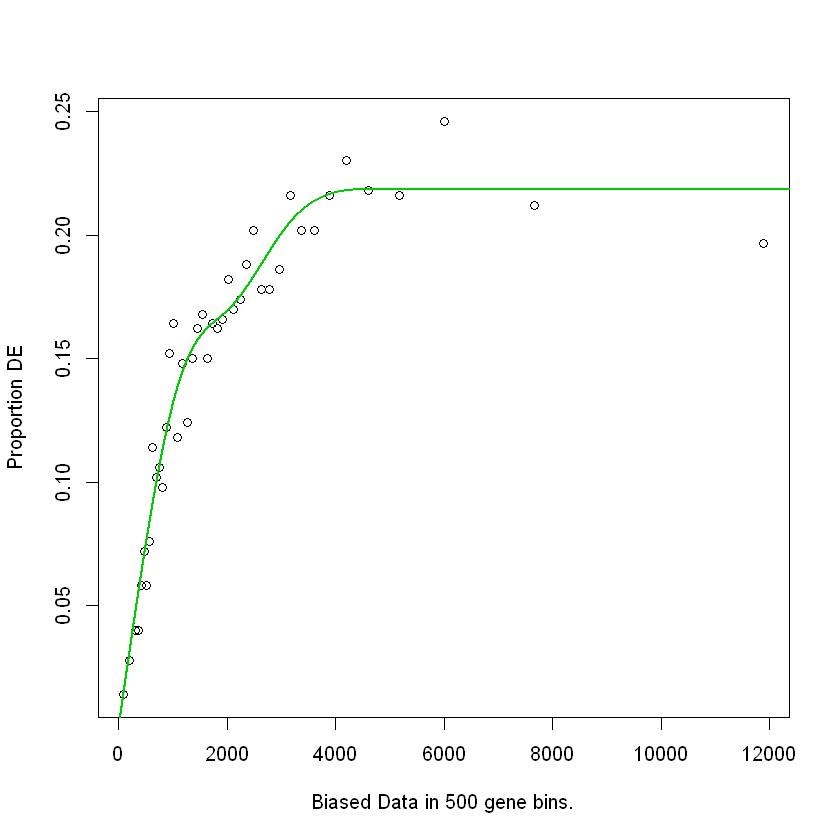

In [21]:
## Compute the probability weighting function for a set of genes based on their status, and 
## use the results obtained to compute the enrichment. Take a look at the enrichment
wtFunc <- nullp(myTags,"hg19","ensGene")      #Compute the probability weighting function
head(wtFunc)

In [22]:
myEnrich_wall <- goseq(wtFunc,"hg19","ensGene", test.cats=c("GO:BP"))    # compute the enrichment
head(myEnrich_wall)                                                      # take a look 

Fetching GO annotations...

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following object is masked from 'package:base':

    expand.grid



Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows




For 9548 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1489,GO:0006614,3.019898e-08,1.0000000,34,93,SRP-dependent cotranslational protein targeting to membrane,BP
1488,GO:0006613,3.418803e-08,1.0000000,35,96,cotranslational protein targeting to membrane,BP
6794,GO:0045047,4.402211e-08,1.0000000,35,97,protein targeting to ER,BP
1612,GO:0006793,5.662022e-08,1.0000000,596,2441,phosphorus metabolic process,BP
1613,GO:0006796,1.662871e-07,1.0000000,587,2418,phosphate-containing compound metabolic process,BP
10666,GO:0072599,2.859017e-07,0.9999999,35,101,establishment of protein localization to endoplasmic reticulum,BP


In [23]:
## Use the `GO.db` package to look at the meaning of a GO category
library(GO.db)
GOTERM[[myEnrich_wall$category[1]]]

GOID: GO:0006614
Term: SRP-dependent cotranslational protein targeting to membrane
Ontology: BP
Definition: The targeting of proteins to a membrane that occurs during
    translation and is dependent upon two key components, the
    signal-recognition particle (SRP) and the SRP receptor. SRP is a
    cytosolic particle that transiently binds to the endoplasmic
    reticulum (ER) signal sequence in a nascent protein, to the large
    ribosomal unit, and to the SRP receptor in the ER membrane.
Synonym: ER translocation
Synonym: SRP-dependent cotranslational membrane targeting
Synonym: SRP-dependent cotranslational protein-membrane targeting

This part is similar to the previous part, `dealing with the edgeR package`. Till step 5, here computed the genes or tags of interest and we have the Ensembl IDs for the tags. The `goseq` function fetched the GO category for the Ensembl genes obtained in step 5. In this part, we used only the biological process category, but for other categories, we can use the values `GO:CC` or `GO:MF`. Besides fetching the GO annotation, the `goseq` function also computes the enrichment in terms of over and under representation of p-values. Finally, the use of the `GO.db` package gives the actual GO term details for the categories retrieved.

## 9. The KEGG enrichment of sequence data

We have done the GO enrichment of sequence data, and we also can do a similar analysis in terms of KEGG annotations.
Take the same data and packages used in the GO analysis.

In [24]:
library(goseq)
library(edgeR)
library(org.Hs.eg.db)   #load the library

In [25]:
## The first four columns in the data are controls and the last three are the treatment samples. 
## Assign these attributes to the data and perform the differential tag computation
myData <- read.table(system.file("extdata", "Li_sum.txt",package = 'goseq'), 
                     sep = '\t', header = TRUE, stringsAsFactors = FALSE,row.names = 1)   #assign the data
# myData <- read.table("path/to/code/files/Li_sum.txt", sep = '\t', header = TRUE, stringsAsFactors = FALSE,row.names=1)

In [26]:
myTreat <- factor(rep(c("Control","Treatment"),times = c(4,3)))
myDG <- DGEList(myData,lib.size = colSums(myData),group = myTreat)    #create `DGElist` object
myDisp <- estimateCommonDisp(myDG)
mytest <- exactTest(myDisp)

In [27]:
## Use the genes from this analysis for enrichment, so extract the genes with the desired p-value and log fold change condition 
## with their corresponding gene names, creating a named vector
myTags <- as.integer(p.adjust(mytest$table$PValue[mytest$table$logFC!=0], method = "BH") < 0.05)
names(myTags) <- row.names(mytest$table[mytest$table$logFC!=0,])

In [28]:
## Compile the KEGG data for enrichment, starting with the conversion of ENSEMBL IDs to Entrez
en2eg <- as.list(org.Hs.egENSEMBL2EG)

## Get all the KEGG IDs for the compiled Entrez IDs, and get the KEGG and Entrez IDs mapped together
eg2kegg <- as.list(org.Hs.egPATH)
grepKEGG <- function(id,mapkeys){unique(unlist(mapkeys[id], use.names = FALSE))}
kegg <- lapply(en2eg,grepKEGG,eg2kegg)

Loading hg19 length data...

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

For 18658 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat
,<chr>,<dbl>,<dbl>,<int>,<int>
88,03010,6.331426e-06,0.9999980,29,87
77,00900,2.393680e-04,0.9999710,10,15
113,04115,8.178449e-04,0.9996829,26,64
175,04964,2.152488e-03,0.9995921,10,17
27,00330,3.673147e-03,0.9986576,18,44
20,00250,5.204967e-03,0.9984341,13,28


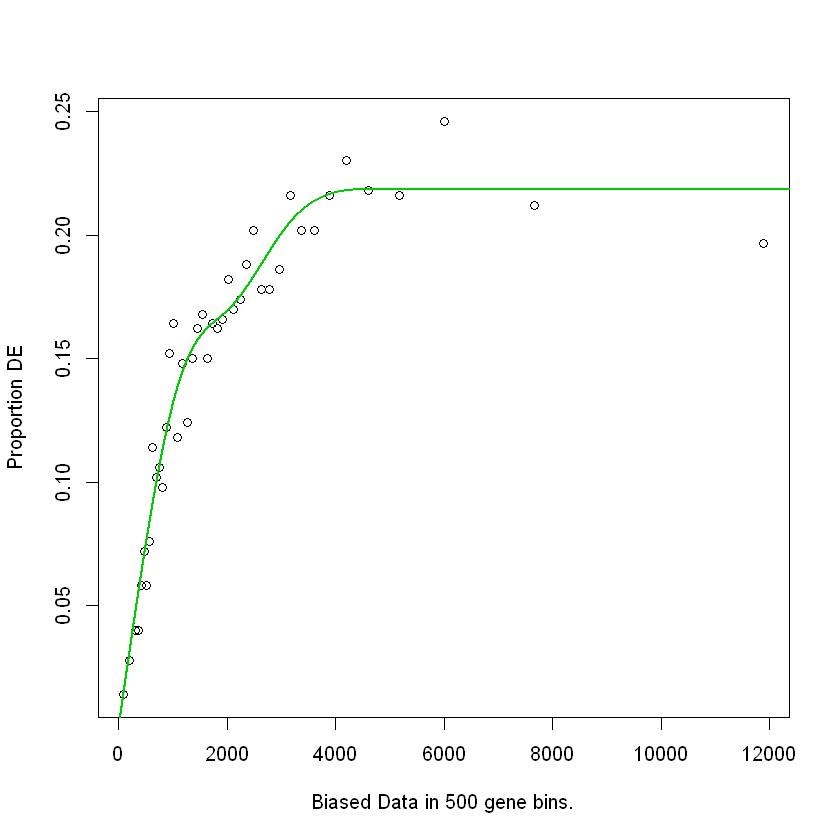

In [29]:
## Compute the probability weighting function, and use the `goseq` function with KEGG mappings for the enrichment of tags
pwf <- nullp(myTags,"hg19","ensGene")
KEGG <- goseq(pwf,gene2cat = kegg)
head(KEGG)

The above plot shows the KEGG enrichment of the data.

This part is very similar to the previous part. However, in this part, its aim is to find the KEGG annotation in place of GO categories. Until step 3, we fetch the differentially expressed tags from data as we did in previous part followed by the extraction of genes of interest(meeting the p-value and log fold change values). Step 4 gets the Entrez mapping of the ENSEMBL genes, which is followed by the corresponding KEGG mapping (of Entrez genes)later. Finally, we extract the KEGG annotation of the interesting genes from the entire list and compute the enrichment scores.

## 10. Analyzing methylation data

DNA methylation data can help to detect an epigenetic marker for which a detailed mechanism of mitotic inheritance has been described. It is usually done via methylation-specific DNA sequencing or via microarray data epigenetic regulation. Recent advances in NGS and microarray technology make it possible to map genome-wide DNA methylation at a high resolution and in a large number of samples. One of the common goals in analyzing methylation data is to identify differentially methylated regions (DMRs) when comparing control and treatment conditions. This recipe aims to address this issue.

Here use the `methyAnalysis` package and the built-in dataset as an example.

In [30]:
BiocManager::install(c("methyAnalysis", "TxDb.Hsapiens.UCSC.hg19.knownGene"))

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'methyAnalysis', 'TxDb.Hsapiens.UCSC.hg19.knownGene'

also installing the dependencies 'rhdf5', 'bumphunter', 'beanplot', 'nor1mix', 'DelayedMatrixStats', 'HDF5Array', 'nleqslv', 'FDb.InfiniumMethylation.hg19', 'minfi', 'lumi', 'methylumi', 'Gviz', 'genoset'




package 'rhdf5' successfully unpacked and MD5 sums checked
package 'bumphunter' successfully unpacked and MD5 sums checked
package 'beanplot' successfully unpacked and MD5 sums checked
package 'nor1mix' successfully unpacked and MD5 sums checked
package 'DelayedMatrixStats' successfully unpacked and MD5 sums checked
package 'HDF5Array' successfully unpacked and MD5 sums checked
package 'nleqslv' successfully unpacked and MD5 sums checked
package 'minfi' successfully unpacked and MD5 sums checked
package 'lumi' successfully unpacked and MD5 sums checked
package 'methylumi' successfully unpacked and MD5 sums checked
package 'Gviz' successfully unpacked and MD5 sums checked
package 'genoset' successfully unpacked and MD5 sums checked
package 'methyAnalysis' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Master\AppData\Local\Temp\RtmpiWAE7A\downloaded_packages


installing the source packages 'FDb.InfiniumMethylation.hg19', 'TxDb.Hsapiens.UCSC.hg19.knownGene'


Old packages: 'BH', 'bit', 'caTools', 'cli', 'FactoMineR', 'fansi', 'farver',
  'GetoptLong', 'ggridges', 'gplots', 'hms', 'knitr', 'leaps', 'multcomp',
  'mvtnorm', 'PMA', 'precrec', 'prettyunits', 'pROC', 'RCurl', 'RSQLite',
  'Rttf2pt1', 'shinyjs', 'stringi', 'tinytex', 'xfun', 'XML', 'xts', 'zoo'



In [31]:
library(methyAnalysis)
data(exampleMethyGenoSet)

## Look at different components to get some information, such as samples and location for the data.
slotNames(exampleMethyGenoSet)  # 对象数据的根目录类别
dim(exprs(exampleMethyGenoSet)) # 对象数据二维行列
str(exampleMethyGenoSet)        # 对象数据结构
# head(locData(exampleMethyGenoSet))
# pData(exampleMethyGenoSet)
class(exampleMethyGenoSet)      # 对象数据类别
colnames(exampleMethyGenoSet)   # 对象数据的行名
exampleMethyGenoSet             # 对象数据内容

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windowsLoading required package: grid

Loading required package: GenomeInfoDb

Loading required package: GenomicRanges

Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)

No methods found in package 'RSQLite' for request: 'dbListFields' when loading 'lumi'

No methods found in package 'genoset' for request: 'toGenomeOrder' when loading 'methyAnalysis'



[1] "history"         "annotation"      "rowRanges"       "colData"        
[5] "assays"          "NAMES"           "elementMetadata" "metadata"

[1] 4243    8

Formal class 'MethyGenoSet' [package "methyAnalysis"] with 8 slots
  ..@ history        :'data.frame':	0 obs. of  4 variables:
  .. ..$ submitted  : 'AsIs' logi(0) 
  .. ..$ finished   : 'AsIs' logi(0) 
  .. ..$ command    : 'AsIs' logi(0) 
  .. ..$ lumiVersion: 'AsIs' logi(0) 
  ..@ annotation     : chr "IlluminaHumanMethylation450k.db"
  ..@ rowRanges      :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots


Warning message:
"Not a validObject(): no slot of name "elementType" for this object of class "GRanges""


  .. .. ..@ seqnames       :Formal class 'Rle' [package "IRanges"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 1 level "chr21": 1
  .. .. .. .. ..@ lengths        : int 4243
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ strand         :Formal class 'Rle' [package "IRanges"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. .. .. ..@ lengths        : int 4243
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:4243] 10882029 10883548 10884748 10884967 10884969 10885409 10888524 10891858 10895603 10895780 ...
  .. .. .. .. ..@ width          : int [1:4243] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. .. ..@ NAMES          : chr [1:4243] "cg17035109" "cg06187584" "cg12459059" "cg25450479" ...
  .. .. .. .. ..@ elementType    : chr "integer"
  ..

[1] "MethyGenoSet"
attr(,"package")
[1] "methyAnalysis"

[1] "Sample1" "Sample2" "Sample3" "Sample4" "Sample5" "Sample6" "Sample7"
[8] "Sample8"

class: MethyGenoSet 
dim: 4243 8 
metadata(0):
assays(4): unmethylated methylated detection exprs
rownames(4243): cg17035109 cg06187584 ... cg07468397 cg08821909
rowData names(1): ID
colnames(8): Sample1 Sample2 ... Sample7 Sample8
colData names(1): SampleType

In [32]:
## The data has two sample conditions, which are Type1 and Type2(we can see it is in the `colData` component). 
## Smoothen the input data with a desired window size (here, it is 200)
methylSmooth <- smoothMethyData(exampleMethyGenoSet, winSize =200) #Might get some warning messages
attr(methylSmooth,'windowSize')

Smoothing Chromosome chr21 ...


[1] 200

In [33]:
## Extract the sample conditions from the `colData` component, and take the input data and sample type from the preceding step
## and detect the `DMRs` in the data. And then, take a look at the object created.
conditons <- colData(exampleMethyGenoSet)$SampleType                    #Extract the sample conditions from the colData
myDMR <- detectDMR.slideWin(exampleMethyGenoSet, sampleType = conditons)#Might get some warning messages
head(myDMR)
#The following screenshot shows the first six entries in the MyDMR object:

Smoothing Chromosome chr21 ...


GRanges object with 6 ranges and 11 metadata columns:
             seqnames    ranges strand |    PROBEID         difference
                <Rle> <IRanges>  <Rle> |   <factor>          <numeric>
  cg17035109    chr21  10882029      * | cg17035109  -1.84116050891237
  cg06187584    chr21  10883548      * | cg06187584 -0.456605878544024
  cg12459059    chr21  10884748      * | cg12459059 -0.359117942730594
  cg25450479    chr21  10884967      * | cg25450479 -0.359117942730594
  cg23347501    chr21  10884969      * | cg23347501 -0.359117942730594
  cg03661019    chr21  10885409      * | cg03661019 -0.353266150910433
                        p.value          p.adjust             tscore
                      <numeric>         <numeric>          <numeric>
  cg17035109 0.0627644943115837  0.18884880818101  -2.28040907618597
  cg06187584  0.416014860951571  0.61495957661053 -0.873425189908341
  cg12459059  0.365421521707119 0.562790422031127 -0.978927000428536
  cg25450479  0.365421521707119 0

In [34]:
## Finally, to identify the significant DMRs, run `identifySigDMR` in the output
mySigDMR <- identifySigDMR(myDMR)
mySigDMR

$sigDMRInfo
GRanges object with 14 ranges and 7 metadata columns:
       seqnames            ranges strand | NumOfProbe  min_p.value
          <Rle>         <IRanges>  <Rle> |  <integer>    <numeric>
   [1]    chr21 19191045-19191320      * |          3 0.0001235924
   [2]    chr21          34522588      * |          1 7.677523e-06
   [3]    chr21          37851847      * |          1 9.416121e-05
   [4]    chr21          38066047      * |          1 1.131734e-05
   [5]    chr21 38075599-38077042      * |          4 2.609326e-07
   ...      ...               ...    ... .        ...          ...
  [10]    chr21          42217001      * |          1  7.22781e-05
  [11]    chr21          43652704      * |          1 0.0002190184
  [12]    chr21 45139229-45139379      * |          2 0.0002073719
  [13]    chr21          47876058      * |          1 4.405417e-06
  [14]    chr21 47878552-47878975      * |          5  5.00709e-07
       max_difference min_p.adjust    max_tscore        mean_Ty

In [35]:
## Get the annotation information for the regions from UCSC, and finally, export the results of analysis
dmr_anno <- annotateDMRInfo(mySigDMR,'TxDb.Hsapiens.UCSC.hg19.knownGene')
export.DMRInfo(dmr_anno, savePrefix='testExample')

Loading required package: TxDb.Hsapiens.UCSC.hg19.knownGene

Loading required package: GenomicFeatures



The example data we used in this part is an extension of the `eSet` class, bearing slots for the different types of information such as samples, chromosomes, and genomic ranges. The analysis begins with data smoothing. The function considers the correlation in the nearby CpG sites in terms of the defined window (here, it is 200), thus reducing the noise. With the less noisy data in place, `detectDMR.slideWin` checks whether the region (smoothed) is differentially methylated based on the `t test` or `wilcox test`, which is then merged to get the continuous regions by calling the `getContinuousRegion` function. The results annotated with the genome data are finally exported as `CSV` files in step 6. <br>

A differentially methylated region, which we aimed to find in this part, is a region where most of the CpG sites are methylated. What we did here was the detection of probe methylation status from the `exampleMethyGenoSet` object. Finally, we mapped these regions onto the chromosomal maps. In this part, we saw the SIM2, ERG, DIP2, and so on, regions being substantially methylated on chromosome 21, where the p-value was less than 0.05. The input data for the part was an `eSet` object. However, it can be in other formats such as a `CSV` or `txt` file. The approach to create `eSet` from these files has been already explained in Chapter 5, Analyzing Microarray Data with R.

## 11. Analyzing ChipSeq data

Chromatin immuneprecipitation sequencing (ChipSeq) is a method to identify genome-wide DNA binding sites for a protein of interest. It is often used to determine the binding sites for transcription factors, DNA-binding enzymes, histones, chaperones, or nucleosomes. The workflow to produce the ChipSeq data starts from the cross-links bound proteins and chromatin. The chromatin is fragmented, and the DNA fragments bound to one protein are captured using an antibody specific to it. The ends of the captured fragments are sequenced using NGS. The computational mapping of the sequenced DNA leads to the identification of the genomic locations of these fragments, illuminating their role in DNA
protein interactions and epigenetics research. The `ChipSeq` data consists of short reads in a `FASTQ` file format. There is a short read after every fifth line of the file. This part will deal with the analysis of the ChipSeq data in R.<br>

Here requires the `chipseq` package and the built-in data in the package for demonstration purposes. And it also needs the mouse genome data for the biological mapping of results.

In [36]:
BiocManager::install(c("chipseq", "TxDb.Mmusculus.UCSC.mm9.knownGene"))
library(TxDb.Mmusculus.UCSC.mm9.knownGene)   # load the library
library(chipseq)    #load the library
data(cstest)        #use the built-in package dataset named `cstest`
cstest              #take a look at the data 

Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'chipseq', 'TxDb.Mmusculus.UCSC.mm9.knownGene'



package 'chipseq' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Master\AppData\Local\Temp\RtmpiWAE7A\downloaded_packages


installing the source package 'TxDb.Mmusculus.UCSC.mm9.knownGene'


Old packages: 'BH', 'bit', 'caTools', 'cli', 'FactoMineR', 'fansi', 'farver',
  'GetoptLong', 'ggridges', 'gplots', 'hms', 'knitr', 'leaps', 'multcomp',
  'mvtnorm', 'PMA', 'precrec', 'prettyunits', 'pROC', 'RCurl', 'RSQLite',
  'Rttf2pt1', 'shinyjs', 'stringi', 'tinytex', 'xfun', 'XML', 'xts', 'zoo'

Loading required package: ShortRead

Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:methyAnalysis':

    rowRanges


The following objects are masked from 'package:Biobas

GRangesList object of length 2:
$ctcf 
GRanges object with 450096 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]    chr10     3012936-3012959      +
       [2]    chr10     3012941-3012964      +
       [3]    chr10     3012944-3012967      +
       [4]    chr10     3012955-3012978      +
       [5]    chr10     3012963-3012986      +
       ...      ...                 ...    ...
  [450092]    chr12 121239376-121239399      -
  [450093]    chr12 121245849-121245872      -
  [450094]    chr12 121245895-121245918      -
  [450095]    chr12 121246344-121246367      -
  [450096]    chr12 121253499-121253522      -

...
<1 more element>
-------
seqinfo: 35 sequences from an unspecified genome

In [37]:
## 2. Estimate the length of the fragments in the data
estimate.mean.fraglen(cstest$ctcf)


## 3. Extend the fragments to cover the binding sites in the sequences. 
## Use an extension length inspired by the fragment lengths in the last step (length =200 > estimate.mean.fraglen(cstest$ctcf))
ctcf_ext <- resize(cstest$ctcf, width = 200)
gfp_ext <- resize(cstest$gfp, width = 200)
# A useful summary of this information is the coverage, that is, how many times each
# base in the genome was covered by one of these intervals and can be computed
cov_ctcf <- coverage(ctcf_ext)
cov_gfp <- coverage(gfp_ext)
cov_ctcf

chr10    chr11    chr12 
179.6794 172.4884 181.6732

RleList of length 35
$chr1
integer-Rle of length 197195432 with 1 run
  Lengths: 197195432
  Values :         0

$chr2
integer-Rle of length 181748087 with 1 run
  Lengths: 181748087
  Values :         0

$chr3
integer-Rle of length 159599783 with 1 run
  Lengths: 159599783
  Values :         0

$chr4
integer-Rle of length 155630120 with 1 run
  Lengths: 155630120
  Values :         0

$chr5
integer-Rle of length 152537259 with 1 run
  Lengths: 152537259
  Values :         0

...
<30 more elements>

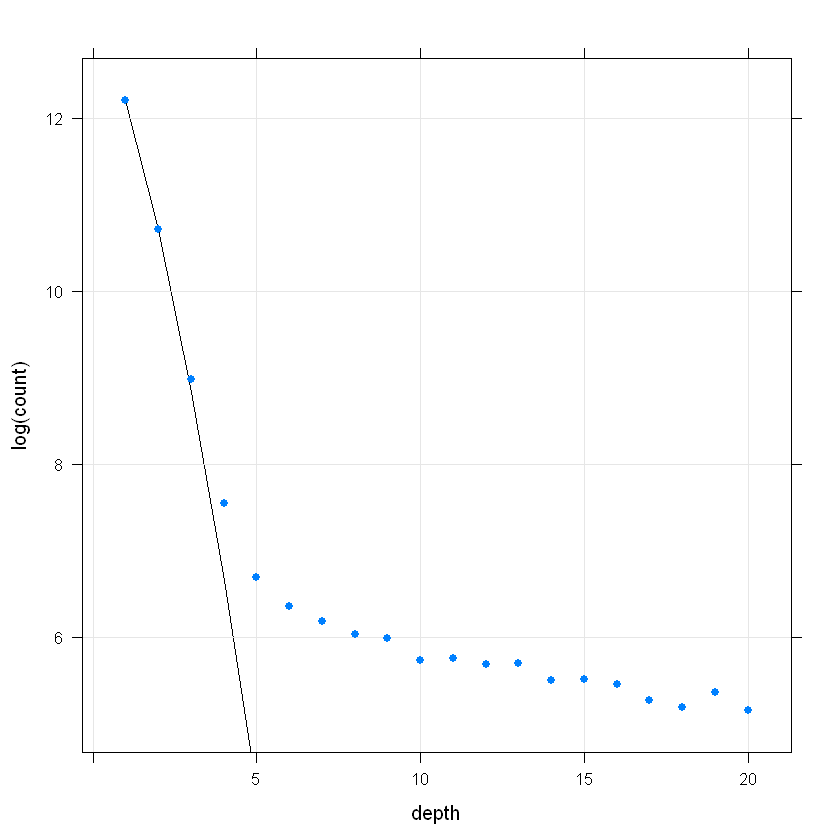

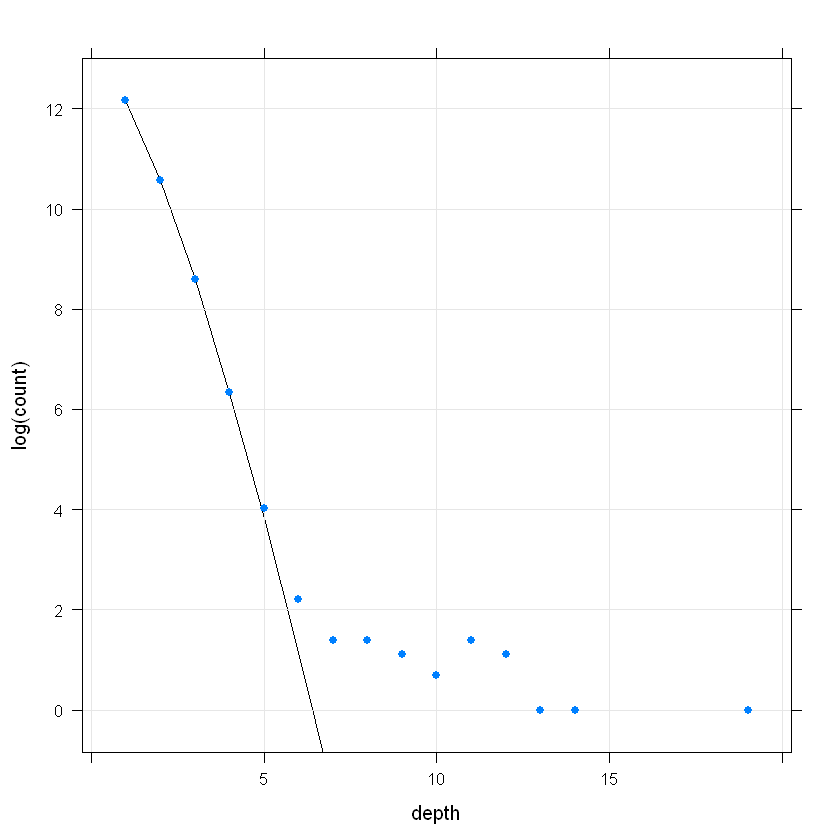

In [38]:
## 4. Create a plot called islands for the regions of interest. They are contiguous segments
library(lattice)
par(mfrow = c(2, 1))
islandDepthPlot(cov_ctcf)
islandDepthPlot(cov_gfp)
# In the following plot, the x axis shows the depth, whereas the y axis shows the corresponding log counts 
# overall, the plot shows the coverage for the sample data

In [39]:
## 5. Compute the peak's cut off for a desired `fdr` (here, 0.01)
peakCutoff(cov_ctcf, fdr = 0.01)
peakCutoff(cov_gfp, fdr = 0.01)

[1] 5.091909

[1] 6.979273

In [40]:
## 6. With this value, decide a cut-off value (7) to be used to get the peaks with high coverage in the segments of the data 
## for both lanes, `ctcf` and `gfp`(note that the chosen cut off is based on computation above 5.09 and 6.97)

peaks_ctcf <- slice(cov_ctcf, lower = 7)
peaks_gfp <- slice(cov_gfp, lower = 7)

In [46]:
## 7. Compute the differential peaks with `diffPeakSummary` function to determine which peaks are different in the two samples. 
## And visualize the results in terms of an XY plot
peakSummary <- diffPeakSummary(peaks_gfp, peaks_ctcf)
head(data.frame(peakSummary))

,seqnames,start,end,width,strand,comb.max,sums1,sums2,maxs1,maxs2
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>
1,chr10,3012944,3013140,197,*,11,0,1911,0,11
2,chr10,3135027,3135029,3,*,7,0,21,0,7
3,chr10,3234798,3234896,99,*,10,0,910,0,10
4,chr10,3234924,3234933,10,*,7,0,70,0,7
5,chr10,3270010,3270301,292,*,20,164,4072,1,19
6,chr10,3277660,3277861,202,*,13,0,1897,0,13


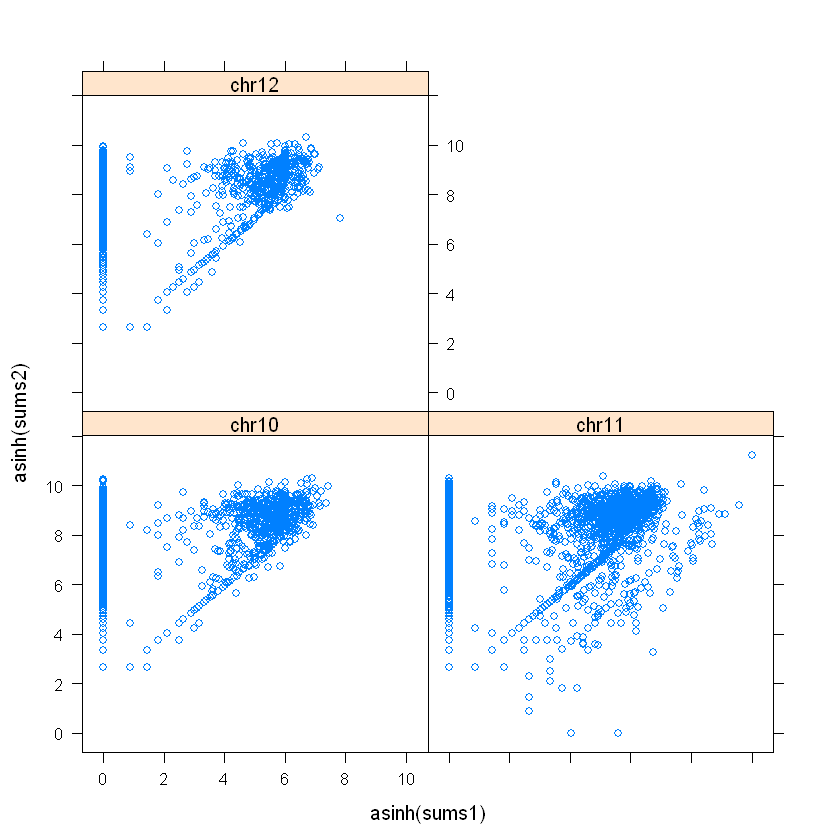

In [56]:
xyplot(asinh(sums2) ~ asinh(sums1) | seqnames, data = as.data.frame(peakSummary))

In [57]:
## 8. Here are the peaks. 
## Find if they are in the region of interest (promoter region). 
## And take a look at the peaks in the promoter region by looking at the object created in the previous step.

gregions <- transcripts(TxDb.Mmusculus.UCSC.mm9.knownGene)
promoters <- flank(gregions, 1000, both = TRUE)
peakSummary$inPromoter <- peakSummary %over% promoters
which(peakSummary$inPromoter)

[1]    2   14   41   51  100  101  110  124  126  130  133  141  155  156  157
 [16]  158  175  176  177  180  184  185  211  212  213  217  218  257  273  276
 [31]  299  306  307  315  318  319  325  327  328  358  361  362  370  371  375
 [46]  381  386  432  456  460  461  493  499  502  513  527  555  556  566  595
 [61]  596  604  606  607  621  622  623  628  652  657  663  665  676  696  697
 [76]  701  710  715  725  824  825  877  900  914  915  918  919  925  938  942
 [91]  963  976  977  993  996  998 1008 1027 1033 1034 1036 1037 1040 1051 1052
[106] 1055 1056 1057 1059 1067 1068 1071 1072 1076 1079 1080 1087 1091 1108 1109
[121] 1110 1112 1114 1115 1124 1127 1131 1144 1159 1166 1175 1182 1195 1211 1226
[136] 1263 1288 1289 1290 1292 1308 1339 1346 1370 1386 1412 1413 1414 1425 1436
[151] 1463 1491 1495 1496 1497 1498 1549 1556 1557 1573 1580 1590 1600 1608 1609
[166] 1620 1647 1651 1685 1686 1705 1715 1716 1721 1740 1741 1776 1783 1795 1796
[181] 1797 1802 1803 1804 1831 1834 1836 1838 1845 1847 1848 1850 1855 1857 1865
[196] 1866 1869 1870 1875 1878 1881 1882 1883 1937 1938 1939 1940 1941 1942 1943
[211] 1944 1966 1967 1968 1969 2034 2035 2036 2037 2038 2039 2040 2051 2053 2058
[226] 2063 2066 2081 2093 2094 2095 2098 2102 2127 2134 2137 2150 2153 2154 2159
[241] 2164 2172 2182 2183 2202 2218 2235 2236 2237 2238 2240 2248 2268 2300 2302
[256] 2330 2334 2336 2338 2339 2365 2367 2372 2375 2378 2379 2380 2412 2413 2419
[271] 2452 2503 2560 2586 2591 2592 2637 2656 2659 2666 2667 2675 2697 2703 2711
[286] 2712 2714 2723 2763 2770 2771 2785 2804 2832 2846 2893 2899 2900 2911 2918
[301] 2919 2929 2932 2946 2948 2954 2970 2974 2988 2996 3006 3022 3029 3034 3036
[316] 3047 3048 3129 3132 3138 3149 3150 3158 3162 3164 3172 3176 3190 3193 3210
[331] 3211 3215 3216 3218 3226 3229 3230 3233 3236 3242 3245 3255 3256 3260 3264
[346] 3277 3280 3281 3290 3310 3316 3317 3318 3326 3329 3330 3331 3334 3353 3356
[361] 3357 3389 3391 3392 3393 3394 3402 3423 3427 3432 3442 3452 3479 3488 3497
[376] 3504 3505 3526 3560 3564 3570 3573 3579 3586 3587 3588 3598 3599 3631 3632
[391] 3633 3635 3638 3648 3680 3688 3693 3719 3730 3751 3754 3755 3766 3768 3771
[406] 3778 3792 3793 3801 3810 3847 3862 3864 3865 3866 3870 3871 3884 3890 3895
[421] 3900 3902 3903 3919 3959 3961 3975 3996 3997 4000 4001 4006 4007 4008 4016
[436] 4017 4043 4050 4051 4055 4061 4062 4067 4068 4076 4078 4094 4101 4102 4130
[451] 4133 4182 4184 4186 4191 4192 4199 4201 4217 4221 4226 4230 4236 4238 4244
[466] 4263 4265 4266 4270 4280 4281 4290 4295 4301 4321 4322 4329 4331 4332 4333
[481] 4340 4341 4356 4368 4371 4380 4381 4389 4402 4411 4414 4415 4419 4442 4445
[496] 4477 4493 4495 4499 4536 4558 4559 4562 4602 4603 4605 4622 4628 4630 4631
[511] 4632 4633 4634 4640 4645 4655 4659 4661 4668 4672 4675 4676 4678 4679 4695
[526] 4696 4699 4706 4707 4713 4733 4755 4756 4759 4761 4762 4765 4766 4768 4769
[541] 4787 4792 4816 4820 4825 4836 4846 4850 4861 4862 4874 4875 4892 4894 4895
[556] 4897 4912 4914 4919 4920 4938 4939 4946 4950 4952 4966 4979 4980 4982 4989
[571] 4994 5011 5012 5017 5019 5027 5037 5050 5066 5079 5100 5103 5124 5132 5133
[586] 5139 5140 5153 5165 5166 5180 5181 5229 5246 5247 5260 5273 5308 5312 5335
[601] 5362 5395 5405 5410 5411 5412 5413 5438 5441 5455 5456 5467 5479 5480 5489
[616] 5491 5505 5506 5525 5526 5535 5567 5603 5604 5627 5645 5647 5651 5656 5657
[631] 5660 5661 5674 5683 5684 5697 5698 5699 5701 5706 5728 5731 5732 5739 5740
[646] 5758 5759 5763 5779 5792 5794 5815 5825 5909 5947 5948 5962 5979 5996 6022
[661] 6047 6068 6130 6131 6148 6161 6182 6224 6259 6267 6268 6309 6313 6318 6322
[676] 6327 6328 6349 6361 6362

In this part, the input data was from three chromosomes (10, 11, and 12) and in two lanes representing `ctcf` and `gfp` pull-down in mouse. The aim of the analysis is to find which peaks are different in two lanes (samples). The method explained in this part finds the coverage vectors for the data and computes statistical scores for the peaks therein. We start with finding the coverage for both the lanes by extending the reads to cover the binding sites. Thereafter, we define our peaks based on a cut-off value according to the desired `fdr` (0.01, as seen in step 5). The `diffPeakSummary` function then combines a set of peaks for the two lanes and summarizes them. Finally, we map the peaks onto the reference genome in step 7, and select the peaks that lie in the promoter region, which are of interest to find the binding sites (step 8).